### in this notebook we'll try to use the vggnet model

vgg model source : github [link](https://github.com/usef-kh/fer/tree/master/models)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os

In [6]:
class FERdataset(Dataset):
    def __init__(self, path_fer2013csv, path_fer2013newcsv):
        self.fer2013 = pd.read_csv(path_fer2013csv)
        self.fer2013labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        self.fer2013new = pd.read_csv(path_fer2013newcsv)
        self.fer2013newlabels = list(self.fer2013new.columns[2:11])
        
    def __getitem__(self, index):
        '''
        returns an image and its fer2013new label as tensors
        '''
        image = self.fer2013['pixels'].iloc[index]
        image = np.fromstring(image, sep=' ').reshape(48, 48)
        image = torch.tensor(image, dtype=torch.float32) / 255
        
        label = torch.tensor(self.fer2013new.iloc[index][2:11].values.astype('float32')) / 10
        
        return image, label
        
    def __len__(self):
        return self.fer2013.shape[0]
    

In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/FERplus/
  inflating: data/FERplus/.gitignore  
  inflating: data/FERplus/fer2013new.csv  
   creating: data/fer2013/
  inflating: data/fer2013/.gitignore  
  inflating: data/fer2013/fer2013.csv  
  inflating: data/fer2013/README     
  inflating: data/fer2013/fer2013.bib  
  inflating: data/fer2013/README.md  


In [7]:
path_fer2013csv='data/fer2013/fer2013.csv'
path_fer2013newcsv='data/FERplus/fer2013new.csv'
dataset = FERdataset(path_fer2013csv, path_fer2013newcsv)

In [8]:
from torch.utils.data import random_split

In [9]:
traindataset, valdataset, testdataset = random_split(dataset, [int(0.6*len(dataset)), int(0.2*len(dataset)), len(dataset) - (int(0.6*len(dataset)) + int(0.2*len(dataset)))], generator=torch.Generator().manual_seed(42))

In [10]:
print(f'traindataset length: {len(traindataset)}')
print(f'valdataset length: {len(valdataset)}')
print(f'testdataset length: {len(testdataset)}')

traindataset length: 21532
valdataset length: 7177
testdataset length: 7178


In [11]:
len(dataset.fer2013newlabels)

9

In [206]:
class Vgg(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        # self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin1 = nn.Linear(512 * 3 * 3, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        # self.lin3 = nn.Linear(4096, 7)
        # output size changed to 9 because we're using the fer plus labels, not the fer 2013 labels
        self.lin3 = nn.Linear(4096, 9)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        # x = x.view(-1, 512 * 2 * 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)
        
        return x

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [208]:
vggmodel = Vgg().to(device)

In [209]:
vggmodel

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

In [210]:
torch.cuda.is_available()

True

In [211]:
# parameters
epochs = 20
batch_size = 100

In [212]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size, shuffle=True)

In [213]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggmodel.parameters())

In [214]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [215]:
running_loss = []
running_val_loss = []
alltrainacc = []
allvalacc = []

print_every = 20
for e in range(epochs):
    for i,(images, labels) in enumerate(trainloader):
        vggmodel.train()
        images.unsqueeze_(1)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = vggmodel(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        
        if i%print_every == 0:
            # torch.save(vggmodel.state_dict(), os.path.join('/models', 'decoder-%d.pkl' % i))
            vggmodel.eval()
            with torch.no_grad():
                for j,(valimages, vallabels) in enumerate(valloader):
                    val_loss_list = []
                    valimages.unsqueeze_(1)
                    valimages = valimages.to(device)
                    vallabels = vallabels.to(device)
                    
                    val_output = vggmodel(valimages)
                    val_loss = criterion(val_output, vallabels)

                    val_loss_list.append(val_loss.item())
                    
                    # to calculate training accuracy
                    trueargmax = torch.argmax(labels, dim=1)
                    truelabels = trueargmax.cpu().detach().numpy()
                    predargmax = torch.argmax(output, dim=1)
                    predlabels = predargmax.cpu().detach().numpy()
                    
                    # to calculate validation accuracy
                    valtrueargmax = torch.argmax(vallabels, dim=1)
                    valtruelabels = valtrueargmax.cpu().detach().numpy()
                    valpredargmax = torch.argmax(val_output, dim=1)
                    valpredlabels = valpredargmax.cpu().detach().numpy()                    

                val_loss_avg = sum(val_loss_list) / len(val_loss_list)
                
            # calculate training and validation accuracy
            batchtrainacc = accuracy_score(truelabels, predlabels)
            batchvalacc = accuracy_score(valtruelabels, valpredlabels)
            
            # store the training and validation accuracies 
            alltrainacc.append(batchtrainacc)
            allvalacc.append(batchvalacc)

            running_val_loss.append(val_loss_avg)
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item():.5f}, val_loss: {val_loss_avg:.5f}, acc: {batchtrainacc:.5f}, val_acc: {batchvalacc:.5f}')

epoch: 0, iteration: 0, loss: 2.13360, val_loss: 1.88711, acc: 0.17000, val_acc: 0.33766
epoch: 0, iteration: 20, loss: 1.92305, val_loss: 1.93725, acc: 0.28000, val_acc: 0.35065
epoch: 0, iteration: 40, loss: 1.75487, val_loss: 1.75662, acc: 0.50000, val_acc: 0.40260
epoch: 0, iteration: 60, loss: 1.81430, val_loss: 1.81121, acc: 0.34000, val_acc: 0.36364
epoch: 0, iteration: 80, loss: 1.82962, val_loss: 1.83613, acc: 0.31000, val_acc: 0.32468
epoch: 0, iteration: 100, loss: 1.80246, val_loss: 1.76028, acc: 0.34000, val_acc: 0.29870
epoch: 0, iteration: 120, loss: 1.78291, val_loss: 1.80340, acc: 0.44000, val_acc: 0.41558
epoch: 0, iteration: 140, loss: 1.80686, val_loss: 1.78983, acc: 0.35000, val_acc: 0.49351
epoch: 0, iteration: 160, loss: 1.70550, val_loss: 1.82589, acc: 0.41000, val_acc: 0.40260
epoch: 0, iteration: 180, loss: 1.86605, val_loss: 1.87392, acc: 0.24000, val_acc: 0.35065
epoch: 0, iteration: 200, loss: 1.76553, val_loss: 1.89477, acc: 0.35000, val_acc: 0.38961
epoch

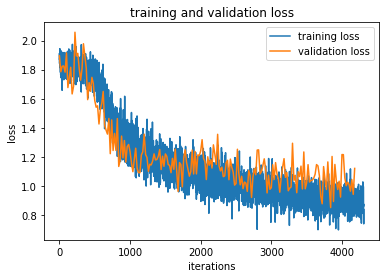

In [216]:
ind = 10
plt.plot(np.arange(len(running_loss[ind:])), running_loss[ind:], label='training loss')
plt.plot(np.arange(len(running_val_loss[ind:]))*print_every, running_val_loss[10:], label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

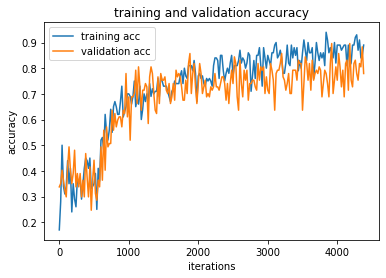

In [217]:
plt.plot(np.arange(len(alltrainacc))*print_every, alltrainacc, label='training acc')
plt.plot(np.arange(len(allvalacc))*print_every, allvalacc, label='validation acc')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

In [218]:
valconfmat = confusion_matrix(valtruelabels, valpredlabels)


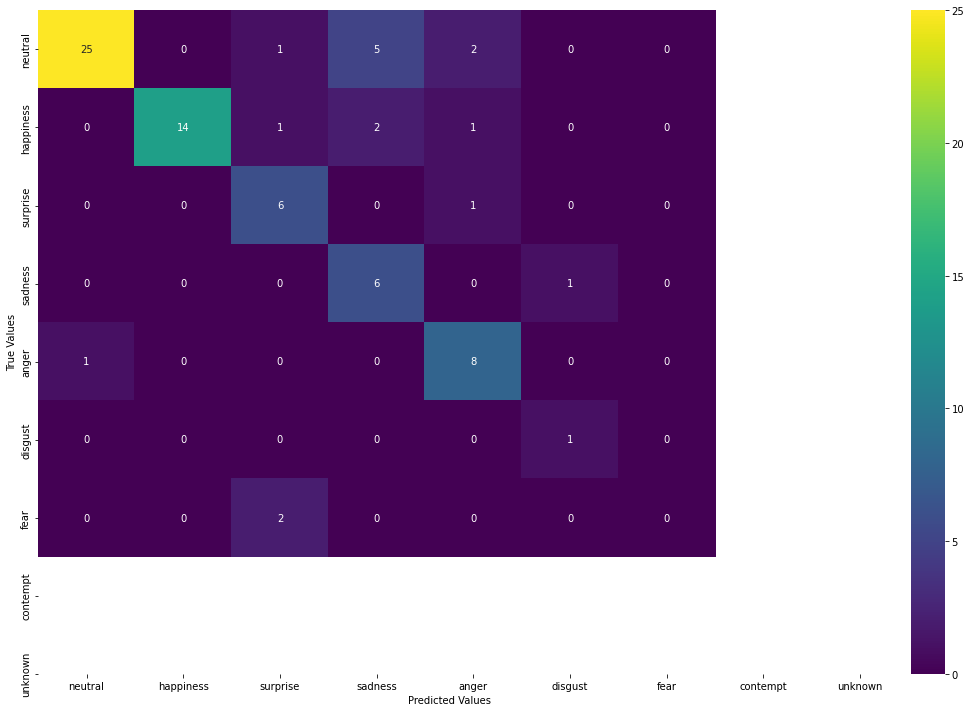

In [219]:
plt.figure(figsize=(15,10))
sns.heatmap(valconfmat, annot=True, fmt='.0f', cmap='viridis', xticklabels=dataset.fer2013newlabels, yticklabels=dataset.fer2013newlabels)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.tight_layout()
plt.show()

In [220]:
testloader = DataLoader(testdataset, 1, shuffle=True)

In [221]:
timage, tlabel = next(iter(testloader))

In [222]:
timage, tlabel = timage.to(device), tlabel.to(device)

In [223]:
timage

tensor([[[0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.6588, 0.6627, 0.6549,  ..., 0.5725, 0.5451, 0.5294],
         [0.6588, 0.6627, 0.6510,  ..., 0.6118, 0.5961, 0.6157],
         [0.6588, 0.6549, 0.6510,  ..., 0.6039, 0.5922, 0.5765]]],
       device='cuda:0')

In [224]:
timage.shape

torch.Size([1, 48, 48])

In [225]:
timage.unsqueeze_(1)

tensor([[[[0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
          [0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
          [0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
          ...,
          [0.6588, 0.6627, 0.6549,  ..., 0.5725, 0.5451, 0.5294],
          [0.6588, 0.6627, 0.6510,  ..., 0.6118, 0.5961, 0.6157],
          [0.6588, 0.6549, 0.6510,  ..., 0.6039, 0.5922, 0.5765]]]],
       device='cuda:0')

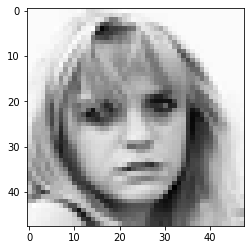

In [226]:
plt.imshow(timage.cpu()[0][0], cmap='gray')

In [227]:
timage.shape

torch.Size([1, 1, 48, 48])

In [228]:
tlabel.shape

torch.Size([1, 9])

In [229]:
tlabel

tensor([[0.7000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000]],
       device='cuda:0')

In [230]:
vggmodel.eval()

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

In [231]:
tpred = vggmodel(timage)
tpred

tensor([[ 3.0140, -2.1953, -2.6868,  1.4015, -1.2069, -2.2329, -2.9686, -0.1206,
         -0.2176]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [232]:
trueargmax = torch.argmax(tlabel)
predargmax = torch.argmax(tpred)

In [233]:
print(trueargmax)
print(predargmax)

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


In [234]:
trueargmax.item()

0

In [235]:
vggmodel.eval()
testtruelabels = []
testpredlabels = []
with torch.no_grad():
    for i, (testimage, testlabel) in enumerate(testloader):
        testimage.unsqueeze_(1)
        testimage, testlabel = testimage.to(device), testlabel.to(device)
        testpred = vggmodel(testimage)

        testtrueargmax = torch.argmax(testlabel).item()
        testpredargmax = torch.argmax(testpred).item()

        testtruelabels.append(testtrueargmax)
        testpredlabels.append(testpredargmax)

In [236]:
testconfmat = confusion_matrix(testtruelabels, testpredlabels)

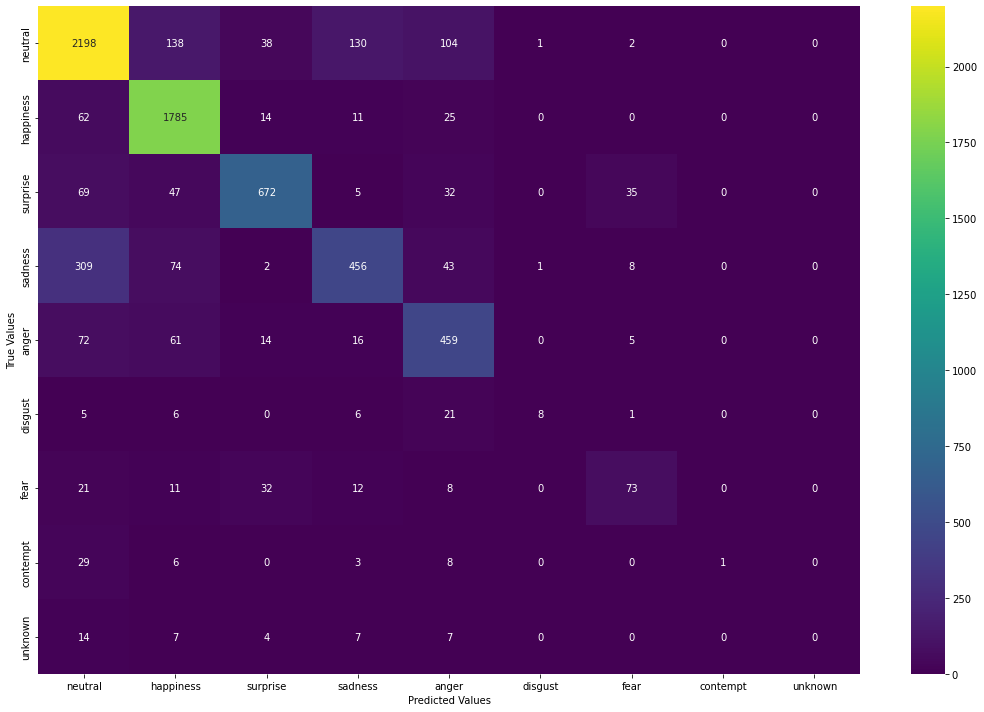

In [237]:
plt.figure(figsize=(15,10))
sns.heatmap(testconfmat, annot=True, fmt='.0f', cmap='viridis', xticklabels=dataset.fer2013newlabels, yticklabels=dataset.fer2013newlabels)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.tight_layout()
plt.show()

In [238]:
accuracy_score(testtruelabels, testpredlabels)

0.7874059626636947

In [239]:
torch.save(vggmodel, 'vggmodel.pth')